## Practice time series with Keras
I took a tutorial on time series and stock predictions, and modified it so that I could use more features than only the feature that is predicted, and also so that I could iterate over combinations of datset settings and hyperparameter settings.
Start with this tutorial:  

```
https://randerson112358.medium.com/stock-price-prediction-using-python-machine-learning-e82a039ac2bb

https://www.youtube.com/watch?v=QIUxPv5PJOY&t=2178s
```
### This notebook is for my learning purposes, and is not particularly clean.

In [1]:
# Description: This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM) to predict the closing stock price of a corporation (Apple Inc.) using the past 60 day stock price.
#Import the libraries

#Egil: The expample was from Colab I think. I need to import keras through tensorflow
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
#Get the stock quote 
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2020-12-31') 
#Show the data 
df.shape


(2265, 6)

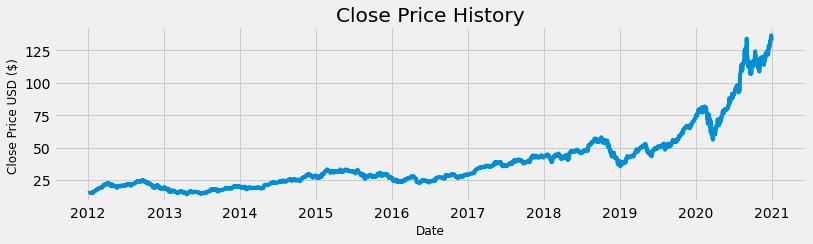

In [2]:
#Visualize the closing price history
plt.figure(figsize=(12,3))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=12)
plt.ylabel('Close Price USD ($)',fontsize=12)
plt.show()

In [3]:

# Build up a new dataprep to make sure I understand it
import itertools
#Create iteration through features and trail_len
features = ['Close', 'Volume'] # Keep the column that is used for y, first
c_i = {f:i for i,f in enumerate(features)} # Overkill if you really keep prediction feature first.
featureset = [features[:f] for f in range(1,len(features)+1)]
trail_len = 60 # How many days to include in each datapoint
epochs = 5

for features, trail_len in itertools.product(featureset, [20,40,60,80]):

    train_part = 0.8
    #Converting the dataframe to a numpy array
    dataset = df.filter(features).values
    training_data_len = math.ceil( len(dataset) *train_part)

    #Scale data used in prediction, between 0 and 1 
    scaler = MinMaxScaler(feature_range=(0, 1)) 

    scaler = scaler.fit(dataset[:training_data_len]) # only training part
    dataset = scaler.transform(dataset)
    '''
    Each column is transformed individually according to the max min of tha column 
    '''
    x_full, y_full = [], []
    for i in range(trail_len, len(dataset)): 
        x_full.append(dataset[i-trail_len:i,0])
        y_full.append(dataset[i,0])

    x_full, y_full = np.array(x_full), np.array(y_full)
    #Reshape the data into the shape accepted by the LSTM
    x_full = np.reshape(x_full, (x_full.shape[0],x_full.shape[1],1))
    print("Full x and y sets shapes", x_full.shape, y_full.shape)

    x_train, x_test = np.split(x_full, [training_data_len-trail_len])
    y_train, y_test = np.split(y_full, [training_data_len-trail_len])

    print ("x and y train and test shapes",x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    print("training_data_len", training_data_len)

    #Build the LSTM network model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))

    #Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    #Train the model
    model.fit(x_train, y_train, batch_size=1, epochs=epochs)

    #Getting the models predicted price values
    predictions = model.predict(x_test) 

    #Put predicted values in right column for scaler
    # -1 in unused columns gives zeroes out of scaler, in case we
    # take the wrong column
    e_c = 'Close' #Evaluation column
    predicted = np.ones(dataset[:len(predictions)].shape)*-1
    predicted[:,c_i[e_c]] = predictions.squeeze()
    y_eval = np.ones(dataset[:len(predictions)].shape)*-1
    y_eval[:, c_i[e_c]] = y_test.squeeze()
    predicted = scaler.inverse_transform(predicted)[:,c_i[e_c]]
    y_eval = scaler.inverse_transform(y_eval)[:,c_i[e_c]]
    # The two should be the same
    print(df[e_c].tail(3))
    print(y_eval[-3:]) 
    print("Predicted:",predicted[-3:])
    rmse=np.sqrt(np.mean(((predicted- y_eval)**2)))
    print(features, trail_len,"\tRMSE:",rmse)
    print()

#rmse 11.8 with Volume og CLose

(2245, 20, 1) (2245,)
(1792, 20, 1) (1792,) (453, 20, 1) (453,)
training_data_len 1812
Epoch 1/5
1792/1792 [==============================] - 21s 11ms/step - loss: 0.0061
Epoch 2/5
1792/1792 [==============================] - 21s 12ms/step - loss: 7.6563e-04
Epoch 3/5
1792/1792 [==============================] - 21s 12ms/step - loss: 4.5151e-04
Epoch 4/5
1792/1792 [==============================] - 20s 11ms/step - loss: 5.4421e-04
Epoch 5/5
1792/1792 [==============================] - 19s 11ms/step - loss: 4.6804e-04
Date
2020-12-29    134.869995
2020-12-30    133.720001
2020-12-31    132.690002
Name: Close, dtype: float64
[134.86999512 133.72000122 132.69000244]
Predicted: [126.89142117 120.22843373 123.21285143]
['Close'] 20 	RMSE: 4.923797122973652

(2225, 40, 1) (2225,)
(1772, 40, 1) (1772,) (453, 40, 1) (453,)
training_data_len 1812
Epoch 1/5
1772/1772 [==============================] - 42s 23ms/step - loss: 0.0059
Epoch 2/5
1772/1772 [==============================] - 39s 22ms/st

Input Data need to be 3-dimensional in the form:

number of samples, number of time steps, and number of features. 

